# CNN Feature Extractor to SVM Classifier

## Purpose

This notebook displays the model I created to clasify animals by their sound.

In [2]:
# Data Manipulation Packages
import os
import numpy as np
import warnings
import subprocess
import librosa
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Keras Packages

# Neural Network Models
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model, Sequential

# Layers and Parameters for CNN
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, GlobalAveragePooling2D, Attention
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop

# SVM 
from sklearn.svm import SVC

# Results Metrics and Plots
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


## Data

The data is from two different datasets sources form GitHub and Kaggle. It includes .wav files from 12 different animals and has 875 observations. The data is preprocessed into a melspectrogram, then stored in a dataframe with the melspectrogram data and the labels.

In [4]:
def preprocess_audio_file(file_path, target_shape=(224, 224)):
    """
    Converts a .wav file into a Mel Spectrogram, resizes it,
    and normalizes pixel values.
    """
    try:
        # Load audio file
        y, sr = librosa.load(file_path, sr=None)
        
        # Validate audio data
        if y is None or len(y) == 0:
            raise ValueError(f"Audio data is empty for file: {file_path}")
        
        # Compute Mel Spectrogram
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        
        # Resize to the target shape
        resized_spec = resize(mel_spec_db, target_shape, mode='constant')
        
        # Normalize and convert to RGB
        rgb_spec = np.stack([resized_spec] * 3, axis=-1) / 255.0  # Normalize to [0, 1]
        return rgb_spec

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        raise

def process_directory_to_dataframe(parent_directory, target_shape=(224, 224)):
    """
    Processes all .wav files in a directory and its subdirectories,
    computes their Mel Spectrograms, and stores them in arrays.
    """
    data, labels = [], []
    for root, _, files in os.walk(parent_directory):
        label = os.path.basename(root)  # Subdirectory name is the label
        for file in files:
            if file.endswith(".wav"):
                file_path = os.path.join(root, file)
                try:
                    # Preprocess the audio file
                    spectrogram = preprocess_audio_file(file_path, target_shape)
                    if spectrogram is not None:
                        data.append(spectrogram)
                        labels.append(label)
                except Exception as e:
                    print(f"Skipping file {file_path} due to error: {e}")

    print(f"Processed {len(data)} files successfully.")
    return np.array(data), np.array(labels)

# Path to the parent directory containing labeled subdirectories of .wav files
parent_directory = "Animal_Sounds" # Replace with your dataset directory

if os.path.exists(parent_directory):
    print(f"Directory exists: {parent_directory}")
else:
    print(f"Directory not found: {parent_directory}")

# Process audio files and labels
print("Processing audio files...")
X, y = process_directory_to_dataframe(parent_directory)

Directory exists: Animal_Sounds
Processing audio files...


Note: Illegal Audio-MPEG-Header 0x66616374 at offset 9082.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


Processed 875 files successfully.


## Encoding and Data Split

This cell encodes the labels and splits the data into the train and test sets. 

In [6]:
# Encode labels
print("Encoding labels...")
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Train-test split
print("Splitting data into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

Encoding labels...
Splitting data into train and test sets...


## Feature Extraction

For the feature extraction model, we're using the MobileNet convolutional neural network (CNN). This model is an efficient CNN pre-trained on the ImageNet dataset. It's optimized for small datasets like the one we are using in this study. We add in a GlobalAveragePooling2D layer as well as a Dense layer for the feature extraction layers.

In [8]:
# Load pre-trained MobileNet model
print("Loading pre-trained MobileNet model...")
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Create a feature extractor from the pre-trained model
feature_extractor_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu')  # Feature embedding layer
])

Loading pre-trained MobileNet model...


### Data Augmentation

In this cell we augment the data to combat overfitting of the classification model in the long run. Additional we extract the features in this cell. 

In [10]:
# Data augmentation and training
datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
datagen.fit(X_train)

# Extract features for training and testing data
print("Extracting features using the pre-trained MobileNet model...")
X_train_features = feature_extractor_model.predict(X_train)
X_test_features = feature_extractor_model.predict(X_test)

Extracting features using the pre-trained MobileNet model...
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 183ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step


## Training the SVM

Here we are using sklearn's SVM package, which we will train on the features extracted from the CNN.

In [12]:
# Train-Test Split after PCA
print("Training the SVM classifier...")

# Train SVM
svm_classifier = SVC(kernel='linear', probability=True, random_state=42)
svm_classifier.fit(X_train_features, np.argmax(y_train, axis=1))

Training the SVM classifier...


SVC(kernel='linear', probability=True, random_state=42)

## SVM Results

Now we are evaluating the results from the SVM on the test set. Additionally, we're printing out a report of how well it performed along with a confusion matrix. 

Evaluating the SVM classifier...
Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.50      0.44        16
           1       0.95      1.00      0.97        19
           2       0.84      0.78      0.81        27
           3       1.00      1.00      1.00         7
           4       0.96      0.93      0.95        28
           5       0.93      0.78      0.85        18
           6       0.91      0.71      0.80        14
           7       1.00      0.67      0.80         9
           8       0.81      0.87      0.84        15
           9       0.10      0.11      0.11         9
          10       0.14      0.33      0.20         3
          11       0.73      0.80      0.76        10

    accuracy                           0.77       175
   macro avg       0.73      0.71      0.71       175
weighted avg       0.80      0.77      0.78       175



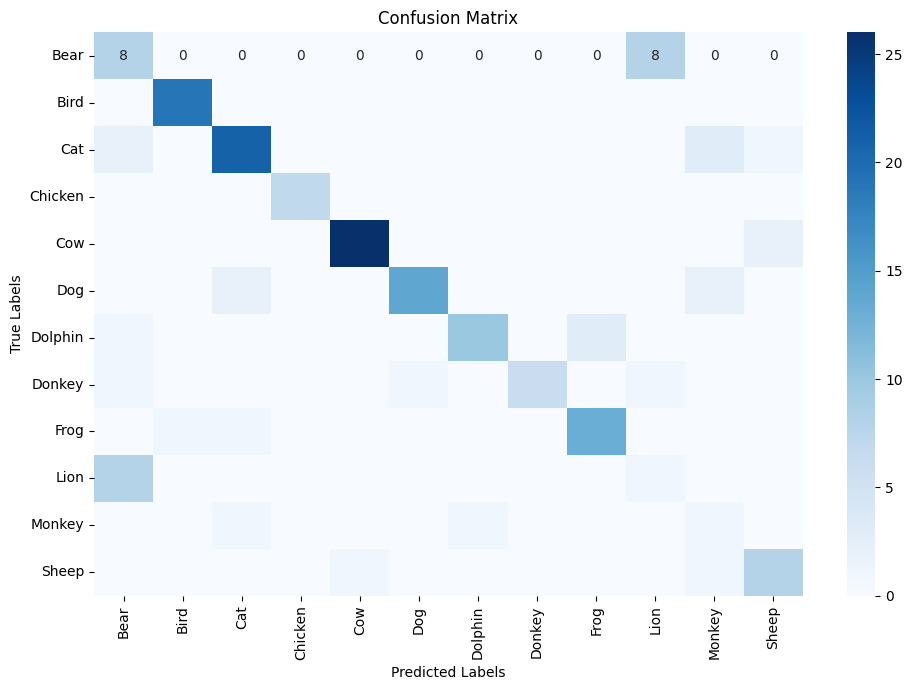

In [14]:
# Evaluate SVM
print("Evaluating the SVM classifier...")
y_pred = svm_classifier.predict(X_test_features)

# Classification Report
print("Classification Report:")
print(classification_report(np.argmax(y_test, axis=1), y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()